## Imports

In [62]:
%load_ext autoreload
%autoreload 2

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pandas and numpy for data manipulation
%matplotlib inline
import pandas as pd
import numpy as np

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
sns.set(font_scale = 1.5)
sns.set_style('ticks')
sns.set()

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Pickle
import joblib

# Data pre-processing
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Import under sampling module from imbalanced learn
from imblearn.under_sampling import RandomUnderSampler
# Import SMOTE from imbalanced learn
from imblearn.over_sampling import SMOTE

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load Cleaned  Data

In [3]:
df = pd.read_csv('../data/cleaned_data_2014_to_2017.csv')
df.head()

,Record,Location,X,Y,Date,Time,Environment,Road_Surface,Traffic_Control,Collision_Location,Light,Collision_Classification,Impact_type,Year,Month,Week_day
0,1,RIDEAU ST @ WALLER ST,368282.69327,5.032275e+06,2014-02-21,06:07:00,02 - Rain,02 - Wet,01 - Traffic signal,03 - At intersection,07 - Dark,01 - Fatal injury,07 - SMV other,2014,February,Friday
1,2,HINES RD btwn INNOVATION DR & SOLANDT RD,350172.08885,5.022740e+06,2014-08-02,13:55:00,01 - Clear,01 - Dry,10 - No control,04 - At/near private drive,01 - Daylight,01 - Fatal injury,02 - Angle,2014,August,Saturday
2,4,MONTREAL RD @ BATHGATE DR/BURMA RD,373224.24847,5.034518e+06,2014-07-29,16:31:00,01 - Clear,01 - Dry,01 - Traffic signal,03 - At intersection,01 - Daylight,01 - Fatal injury,05 - Turning movement,2014,July,Tuesday
3,5,RICHMOND RD btwn FALLOWFIELD RD & RUSHMORE RD,358156.20481,5.012570e+06,2014-08-05,20:05:00,01 - Clear,01 - Dry,10 - No control,01 - Non intersection,05 - Dusk,01 - Fatal injury,07 - SMV other,2014,August,Tuesday
4,6,PARKDALE AVE btwn RUSKIN ST & INGLEWOOD PL,365558.54334,5.028338e+06,2014-04-19,10:22:00,01 - Clear,01 - Dry,10 - No control,01 - Non intersection,01 - Daylight,01 - Fatal injury,06 - SMV unattended vehicle,2014,April,Saturday


In [4]:
# Data Shape
df.shape

(57768, 16)

In [5]:
# Datatypes and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57768 entries, 0 to 57767
Data columns (total 16 columns):
Record                      57768 non-null int64
Location                    57768 non-null object
X                           57768 non-null float64
Y                           57768 non-null float64
Date                        57768 non-null object
Time                        57768 non-null object
Environment                 57767 non-null object
Road_Surface                57768 non-null object
Traffic_Control             57733 non-null object
Collision_Location          57762 non-null object
Light                       57766 non-null object
Collision_Classification    57768 non-null object
Impact_type                 57768 non-null object
Year                        57768 non-null int64
Month                       57768 non-null object
Week_day                    57768 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 7.1+ MB


We have 3 numerical and 12 categorical attributes in the dataset. Traffic_Control, Collision_Location, and Light have missing values. We will come back to the missing values later in data preprocessing.


The Year attribute has only four levels, therefore it would be better to consider it as a categorical attributes

In [6]:
# Check unique values
df.Year.unique()

array([2014, 2015, 2016, 2017])

In [7]:
# Convert to object
df.Year = df.Year.astype('O')

We will also drop some attributes that won't be very useful in building predictive model

In [8]:
# Drop specified attributes 
df = df.drop(['Time', 'Date', 'Record','Location'], axis = 1)

In [9]:
# Attrinute names
df.columns

Index(['X', 'Y', 'Environment', 'Road_Surface', 'Traffic_Control',
       'Collision_Location', 'Light', 'Collision_Classification',
       'Impact_type', 'Year', 'Month', 'Week_day'],
      dtype='object')

## Class Distribution

In [10]:
df.Collision_Classification.value_counts()

03 - P.D. only           46790
02 - Non-fatal injury    10885
01 - Fatal injury           93
Name: Collision_Classification, dtype: int64

##  Feature Matrix  and Class Variable

In [11]:
X, y = df.drop(['Collision_Classification'], axis = 1), df['Collision_Classification']

## Create a Test Set

In [12]:
# Create 70% training set and 30% test set using stratify sampling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 42, stratify = y)

In [13]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print("**************************************************")
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 03 - P.D. only           80.997601
02 - Non-fatal injury    18.841655
01 - Fatal injury         0.160744
Name: Collision_Classification, dtype: float64
**************************************************
Test set class distribution:
 03 - P.D. only           80.993595
02 - Non-fatal injury    18.844844
01 - Fatal injury         0.161560
Name: Collision_Classification, dtype: float64


In [14]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (40437, 11) (40437,)
Test set size: (17331, 11) (17331,)


## Impute Missing Value

As we saw above, there are some attributes with missing values. We will now impute the missing values in those attributes for a better performance

In [15]:
# Instantiate the imputer class
imputer = DataFrameImputer()

# Fit transform the training set
X_train_imputed = imputer.fit_transform(X_train)

# Only transform the test set
X_test_imputed = imputer.fit_transform(X_test)

It is good to cross-check whether the missing values have been imputed

In [16]:
# Cross-check for missing values
print(X_train_imputed.isnull().sum())
print('***************************')
print(X_test_imputed.isnull().sum())

X                     0
Y                     0
Environment           0
Road_Surface          0
Traffic_Control       0
Collision_Location    0
Light                 0
Impact_type           0
Year                  0
Month                 0
Week_day              0
dtype: int64
***************************
X                     0
Y                     0
Environment           0
Road_Surface          0
Traffic_Control       0
Collision_Location    0
Light                 0
Impact_type           0
Year                  0
Month                 0
Week_day              0
dtype: int64


## Standardize the Numerical Features and Convert the Categorical Attributes to Binaries
As we saw above, most of the attributes are categorical, and they need to be converted to numeric before applying the machine learning algorithms. We also need to scale the numerical attributes for a better performance

In [17]:
# Numerical attributes list
num_list = list(X.select_dtypes('number'))

# Categorical attributes list
cat_list = list(X.select_dtypes('O'))

# Standardize the numerical attributes
num_attribs = [([num], StandardScaler()) for num in num_list]

# Binarize the categorical attributes
cat_attribs = [([cat], LabelBinarizer()) for cat in cat_list]

# Build a pipeline for the data pre-processing
mapper =  DataFrameMapper(num_attribs + cat_attribs, df_out = True) 

# Fit transform the training set
X_train_prepared = mapper.fit_transform(X_train_imputed)

# Only transform the test set
X_test_prepared = mapper.transform(X_test_imputed)

In [18]:
print('Training set size after pre-processing:', X_train_prepared.shape)
print('Test set size after pre-processing:', X_test_prepared.shape)

Training set size after pre-processing: (40437, 80)
Test set size after pre-processing: (17331, 80)


## Dimensionality Reduction

In [20]:
# PCA with unscaled training data
lda = LDA(n_components = 2)
X_train_reduced = lda.fit_transform(X_train_prepared, y_train)

In [21]:
# Put in dataframe
X_train_reduced = pd.DataFrame(data = X_train_reduced)
X_train_reduced.columns = ['PC1', 'PC2']
X_train_reduced['Class'] = y_train.reset_index(drop = True)
X_train_reduced.head()

,PC1,PC2,Class
0,0.352846,-0.379435,02 - Non-fatal injury
1,-0.077106,-0.827116,02 - Non-fatal injury
2,0.186189,-1.054833,03 - P.D. only
3,0.395714,0.045435,03 - P.D. only
4,-0.033999,-0.813559,03 - P.D. only


In [22]:
# Pickle pca dataframe
X_train_reduced.to_pickle('../data/pca.pkl') 

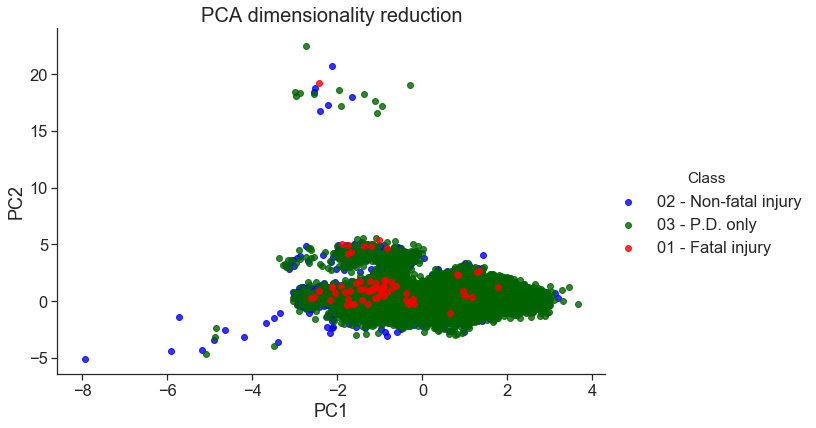

In [52]:
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Load file
X_train_reduced_pca = pd.read_pickle('../data/pca.pkl') 
# Plot
sns.lmplot(data = X_train_reduced_pca, x = 'PC1', y = 'PC2', hue = 'Class', 
           fit_reg = False, height= 6, aspect=1.5, palette = ['blue', 'darkgreen', 'red'])
plt.title('PCA dimensionality reduction', fontsize = 20)
plt.savefig('../image/pca.png')

##  Encode the Class Variable

In [55]:
# Dictionary mapping
map_target = {'01 - Fatal injury': 2, '02 - Non-fatal injury': 1, '03 - P.D. only': 0}

# Map to discrete numbers
y_train_label = y_train.map(map_target)
y_test_label = y_test.map(map_target)